# Hourly PSDS - FFBI & ROMY

## Load Libraries

In [1]:
from obspy import UTCDateTime
from scipy.signal import welch
from numpy import log10, zeros, pi, append, linspace, mean, median, array, where, transpose, shape, histogram, arange
from numpy import logspace, linspace, log, log10, isinf, ones, nan, count_nonzero, sqrt, isnan
from pandas import DataFrame, concat, Series, date_range, read_csv, read_pickle
from tqdm import tqdm
from pathlib import Path

import os, sys
import pickle
import matplotlib.pyplot as plt

from functions.get_fband_average import __get_fband_average
from functions.replace_noise_psd_with_nan import __replace_noisy_psds_with_nan


import warnings
warnings.filterwarnings('ignore')

In [2]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
    bay_path = '/home/andbro/bay200/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'
elif os.uname().nodename == 'lin-ffb-01':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'

## Configurations

In [3]:
config = {}


config['d1'], config['d2'] = "2024-02-01", "2024-02-25"

config['path_to_data'] = data_path+f"LNM2/PSDS/"

config['outpath_figures'] = data_path+f"LNM2/figures/"

config['frequency_limits'] = 1e-3, 1e1

config['year'] = config['d1'][:4]


## Methods

In [4]:
# def __cut_frequencies_array(arr, freqs, fmin, fmax):

#     ind = []
#     for i, f in enumerate(freqs):
#         if f >= fmin and f <= fmax:
#             ind.append(i)

#     ff = freqs[ind[0]:ind[-1]]
#     pp = arr[:,ind[0]:ind[-1]]

#     return pp, ff

In [5]:
def __makeplot_colorlines_overview(config, ff, psds, rejected, names, day, show_rejected=True):

    from tqdm.notebook import tqdm
    from numpy import isnan, median, mean, std, array, zeros
    from scipy.stats import median_abs_deviation as mad

#     psds_median = __get_median_psd(array(psds))
#     psds_minimal = __get_minimal_psd(array(psds))
#     psds_minimum = __get_minimum_psd(array(psds), ff)


    # ## convert frequencies to periods
    # pp=[]
    # for mm in range(len(ff)):
    #     ppp = zeros(len(ff[mm]))
    #     ppp = 1/ff[mm]
    #     pp.append(ppp)


    ##____________________________

    NN = 5

    fig, axes = plt.subplots(NN, 1, figsize=(12, 12), sharey=False, sharex=True)

    plt.subplots_adjust(hspace=0.1)

    font = 14

    N = 24

    colors = plt.cm.rainbow(linspace(0, 1, N))
    cmap = plt.get_cmap('rainbow', 24)


    for j in range(NN):

        try:
            for n, psd in enumerate(psds[j]):
                axes[j].loglog(ff[j], psd, color=colors[n], alpha=0.7)
                p2 = axes[j].scatter(ff[j][0], psd[0], s=0., c=n/N, cmap=cmap, vmin=0, vmax=N, zorder=3)
        except:
            pass

        if show_rejected:
            for reject in rejected[j]:
                axes[j].loglog(ff[j], reject, color='grey', alpha=0.8, zorder=2)

        # axes[j].loglog(ff[j], __get_median_psd(psds[j]), 'black', zorder=3, alpha=0.6, label="Median")

        axes[NN-2].loglog(baro_lnm['frequency'], baro_lnm['nlnm_baro'], color="grey", ls="--", alpha=0.8)
        axes[NN-2].loglog(baro_lnm['frequency'], baro_lnm['nhnm_baro'], color="grey", ls="--", alpha=0.8)

        axes[NN-1].loglog(baro_lnm['frequency'], baro_lnm['nlnm_baro'], color="grey", ls="--", alpha=0.8)
        axes[NN-1].loglog(baro_lnm['frequency'], baro_lnm['nhnm_baro'], color="grey", ls="--", alpha=0.8)

        axes[j].set_xlim(1e-3, 2e0)
        axes[j].grid(True, which="both", ls="-", alpha=0.5)
        # axes[j].legend(loc='lower left')
        axes[j].tick_params(labelsize=font-2)


    ## limits of sensor noise
    # freq = arange(0.0001, 1, 0.001)
    # plim1 = 0.1**2 * ones(len(freq)) / 12 / (0.5*0.1) ## resolution = 0.1 hPa @ 0.1Hz sampling
    # plim2 = 0.1**2 * ones(len(freq)) / 12/ (0.5*1.0) ## resolution = 0.1 hPa @ 0.1Hz sampling

    # plim1_1 = 0.1**2 * ones(len(freq)) / (0.5*0.1) ## resolution = 0.1 hPa @ 0.1Hz sampling
    # plim2_1 = 0.1**2 * ones(len(freq)) / (0.5*1.0) ## resolution = 0.1 hPa @ 0.1Hz sampling

    # axes[1].loglog(freq, plim1, color="black", ls="--", zorder=4, alpha=0.7)
    # axes[2].loglog(freq, plim2, color="black", ls="--", zorder=4, alpha=0.7)

    # axes[1].loglog(freq, plim1_1, color="black", ls=":", zorder=4, alpha=0.7)
    # axes[2].loglog(freq, plim2_1, color="black", ls=":", zorder=4, alpha=0.7)

    axes[0].plot(df_models.frequencies, df_models.nlnm_rot_rate, color="k", ls="--", alpha=0.6)
    axes[1].plot(df_models.frequencies, df_models.nlnm_rot_rate, color="k", ls="--", alpha=0.6)
    axes[2].plot(df_models.frequencies, df_models.nlnm_rot_rate, color="k", ls="--", alpha=0.6)

    axes[NN-1].set_xlabel("Frequency (Hz)", fontsize=font, labelpad=-1)

    ## panel labels
    axes[0].text(.01, .95, '(a)', ha='left', va='top', transform=axes[0].transAxes, fontsize=font)
    axes[1].text(.01, .95, '(b)', ha='left', va='top', transform=axes[1].transAxes, fontsize=font)
    axes[2].text(.01, .95, '(c)', ha='left', va='top', transform=axes[2].transAxes, fontsize=font)
    axes[3].text(.01, .95, '(d)', ha='left', va='top', transform=axes[3].transAxes, fontsize=font)
    axes[4].text(.01, .95, '(e)', ha='left', va='top', transform=axes[4].transAxes, fontsize=font)

    sta, cha = names[0].split("_")[-2], names[0].split("_")[-1]
    axes[0].text(.05, .95, f'{sta}.{cha}', ha='left', va='top', transform=axes[0].transAxes, fontsize=font)

    sta, cha = names[1].split("_")[-2], names[1].split("_")[-1]
    axes[1].text(.05, .95, f'{sta}.{cha}', ha='left', va='top', transform=axes[1].transAxes, fontsize=font)

    sta, cha = names[2].split("_")[-2], names[2].split("_")[-1]
    axes[2].text(.05, .95, f'{sta}.{cha}', ha='left', va='top', transform=axes[2].transAxes, fontsize=font)

    sta, cha = names[3].split("_")[-2], names[3].split("_")[-1]
    axes[3].text(.05, .95, f'{sta}.{cha}', ha='left', va='top', transform=axes[3].transAxes, fontsize=font)

    sta, cha = names[4].split("_")[-2], names[4].split("_")[-1]
    axes[4].text(.05, .95, f'{sta}.{cha}', ha='left', va='top', transform=axes[4].transAxes, fontsize=font)

    axes[0].set_title(day, fontsize=font+2)

    axes[0].set_ylim(bottom=1e-23, top=1e-17)
    axes[1].set_ylim(bottom=1e-23, top=1e-17)
    axes[2].set_ylim(bottom=1e-23, top=1e-17)
    axes[3].set_ylim(bottom=1e-6, top=1e6)
    axes[4].set_ylim(bottom=1e-6, top=1e6)

    axes[0].set_ylabel(r"PSD (rad$^2$/s$^2$/Hz)", fontsize=font)
    axes[1].set_ylabel(r"PSD (rad$^2$/s$^2$/Hz)", fontsize=font)
    axes[2].set_ylabel(r"PSD (rad$^2$/s$^2$/Hz)", fontsize=font)
    axes[3].set_ylabel(r"PSD (Pa$^2$/Hz)", fontsize=font)
    axes[4].set_ylabel(r"PSD (Pa$^2$/Hz)", fontsize=font)

    ## set colorbar at bottom
    cbar = fig.colorbar(p2, orientation='vertical', ax=axes.ravel().tolist(), aspect=50, pad=-1e-5, ticks=arange(1,N,2))


    plt.show();
    return fig

In [6]:
from functions.get_fband_averages import __get_fband_averages
from functions.replace_noise_psd_with_nan import __replace_noisy_psds_with_nan
from functions.get_median_psd import __get_median_psd

## RUN for all files 

In [7]:
baro_lnm = read_csv(data_path+f"LNM2/data/"+"baro_nlnm_nhnm.csv")

baro_lnm['nlnm_baro'] = 10**(baro_lnm['nlnm_baro_db']/10)
baro_lnm['nhnm_baro'] = 10**(baro_lnm['nhnm_baro_db']/10)

In [8]:
df_models = read_csv(data_path+"LNM/data/FINAL/"+"TLNM_to_RLNM.csv")


Data1
 -> 7 are all NaN
 -> 5 rows removed due to mean thresholds (0.0019 and 0.0101 Hz)!
 -> 12 / 24 psds remain

Data2
 -> 20 are all NaN
 -> 1 rows removed due to mean thresholds (0.0019 and 0.0101 Hz)!
 -> 3 / 24 psds remain

Data3
 -> 20 are all NaN
 -> 2 rows removed due to mean thresholds (0.0019 and 0.0101 Hz)!
 -> 2 / 24 psds remain

Data4
 -> 1 are all NaN
 -> 0 rows removed due to mean thresholds (0.001 and 1.0001 Hz)!
 -> 23 / 24 psds remain

Data5
 -> 1 are all NaN
 -> 0 rows removed due to mean thresholds (0.001 and 1.0001 Hz)!
 -> 23 / 24 psds remain


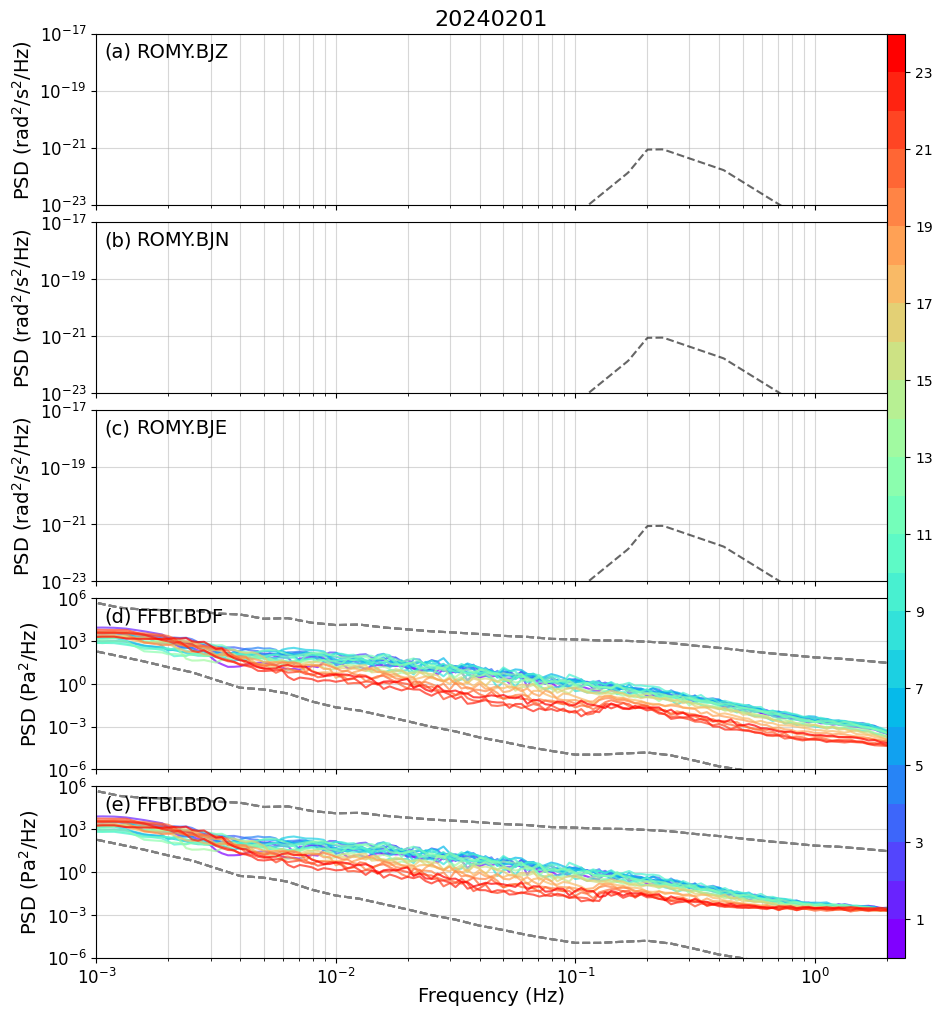

 -> saving: /import/kilauea-data/LNM2/figures/joint_20240201.png

Data1
 -> 6 are all NaN
 -> 2 rows removed due to mean thresholds (0.0019 and 0.0101 Hz)!
 -> 16 / 24 psds remain

Data2
 -> 9 are all NaN
 -> 5 rows removed due to mean thresholds (0.0019 and 0.0101 Hz)!
 -> 10 / 24 psds remain

Data3
 -> 9 are all NaN
 -> 5 rows removed due to mean thresholds (0.0019 and 0.0101 Hz)!
 -> 10 / 24 psds remain

Data4
 -> 0 are all NaN
 -> 0 rows removed due to mean thresholds (0.001 and 1.0001 Hz)!
 -> 24 / 24 psds remain

Data5
 -> 0 are all NaN
 -> 0 rows removed due to mean thresholds (0.001 and 1.0001 Hz)!
 -> 24 / 24 psds remain


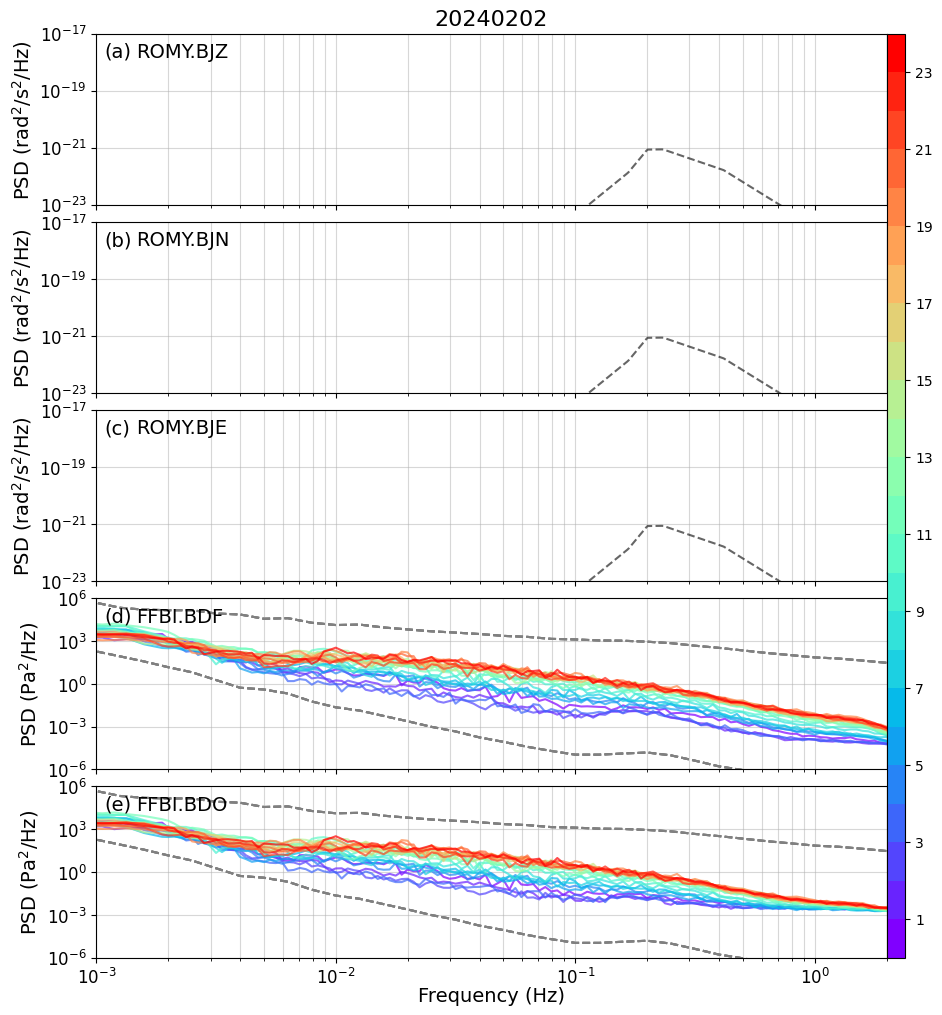

 -> saving: /import/kilauea-data/LNM2/figures/joint_20240202.png

Data1
 -> 5 are all NaN
 -> 1 rows removed due to mean thresholds (0.0019 and 0.0101 Hz)!
 -> 18 / 24 psds remain

Data2
 -> 24 are all NaN
 -> 0 rows removed due to mean thresholds (0.0019 and 0.0101 Hz)!
 -> 0 / 24 psds remain

Data3
 -> 24 are all NaN
 -> 0 rows removed due to mean thresholds (0.0019 and 0.0101 Hz)!
 -> 0 / 24 psds remain

Data4
 -> 0 are all NaN
 -> 0 rows removed due to mean thresholds (0.001 and 1.0001 Hz)!
 -> 24 / 24 psds remain

Data5
 -> 0 are all NaN
 -> 0 rows removed due to mean thresholds (0.001 and 1.0001 Hz)!
 -> 24 / 24 psds remain


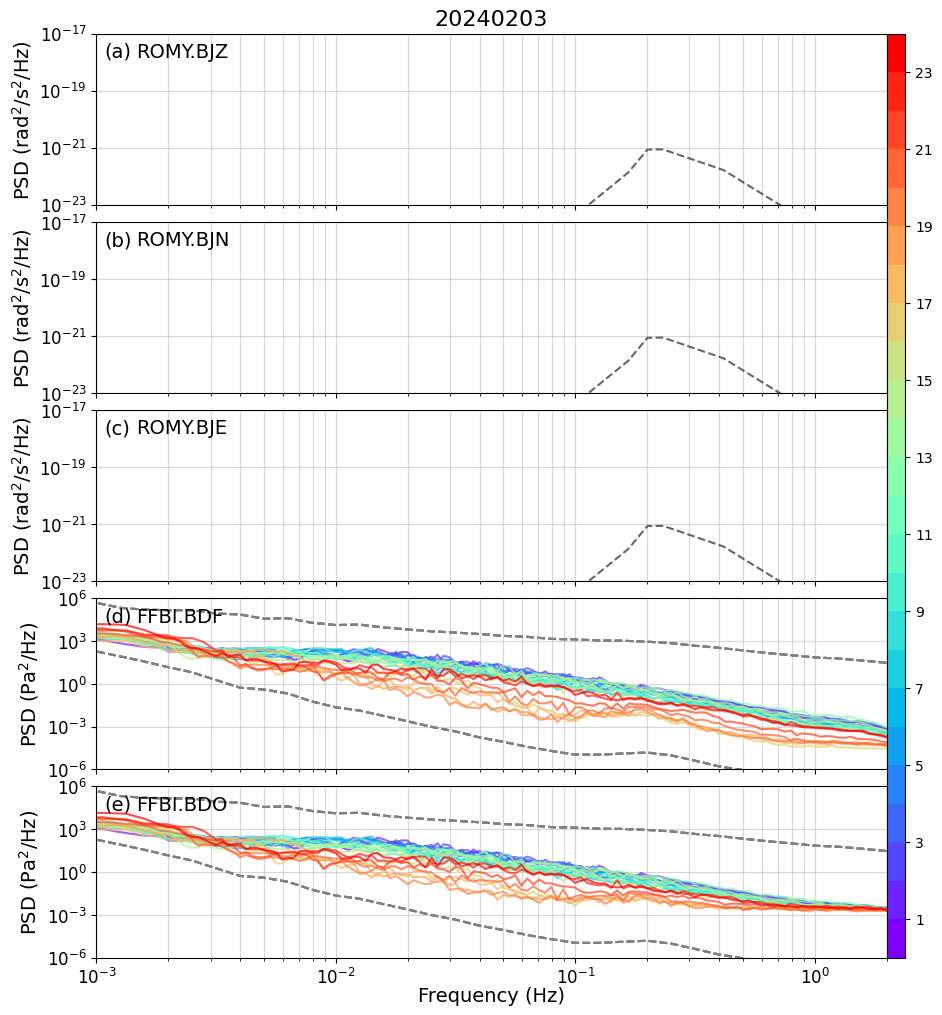

 -> saving: /import/kilauea-data/LNM2/figures/joint_20240203.png

Data1
 -> 19 are all NaN
 -> 0 rows removed due to mean thresholds (0.0019 and 0.0101 Hz)!
 -> 5 / 24 psds remain

Data2
 -> 11 are all NaN
 -> 11 rows removed due to mean thresholds (0.0019 and 0.0101 Hz)!
 -> 2 / 24 psds remain

Data3
 -> 11 are all NaN
 -> 11 rows removed due to mean thresholds (0.0019 and 0.0101 Hz)!
 -> 2 / 24 psds remain

Data4
 -> 0 are all NaN
 -> 0 rows removed due to mean thresholds (0.001 and 1.0001 Hz)!
 -> 24 / 24 psds remain

Data5
 -> 0 are all NaN
 -> 0 rows removed due to mean thresholds (0.001 and 1.0001 Hz)!
 -> 24 / 24 psds remain


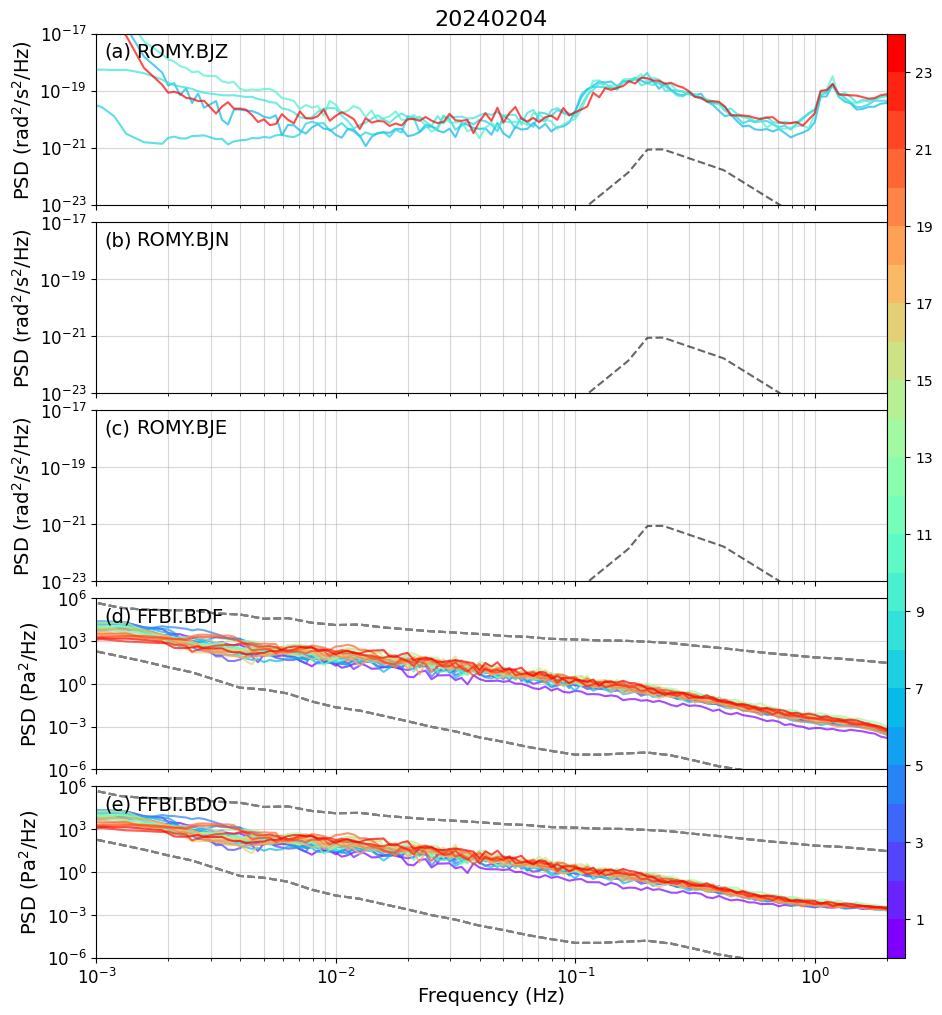

 -> saving: /import/kilauea-data/LNM2/figures/joint_20240204.png

Data1
 -> 6 are all NaN
 -> 6 rows removed due to mean thresholds (0.0019 and 0.0101 Hz)!
 -> 12 / 24 psds remain

Data2
 -> 15 are all NaN
 -> 2 rows removed due to mean thresholds (0.0019 and 0.0101 Hz)!
 -> 7 / 24 psds remain

Data3
 -> 15 are all NaN
 -> 4 rows removed due to mean thresholds (0.0019 and 0.0101 Hz)!
 -> 5 / 24 psds remain

Data4
 -> 4 are all NaN
 -> 1 rows removed due to mean thresholds (0.001 and 1.0001 Hz)!
 -> 19 / 24 psds remain

Data5
 -> 4 are all NaN
 -> 1 rows removed due to mean thresholds (0.001 and 1.0001 Hz)!
 -> 19 / 24 psds remain
 -> saving: /import/kilauea-data/LNM2/figures/joint_20240205.png

Data1
 -> 5 are all NaN
 -> 19 rows removed due to mean thresholds (0.0019 and 0.0101 Hz)!
 -> 0 / 24 psds remain

Data2
 -> 9 are all NaN
 -> 4 rows removed due to mean thresholds (0.0019 and 0.0101 Hz)!
 -> 11 / 24 psds remain

Data3
 -> 9 are all NaN
 -> 4 rows removed due to mean thresholds 

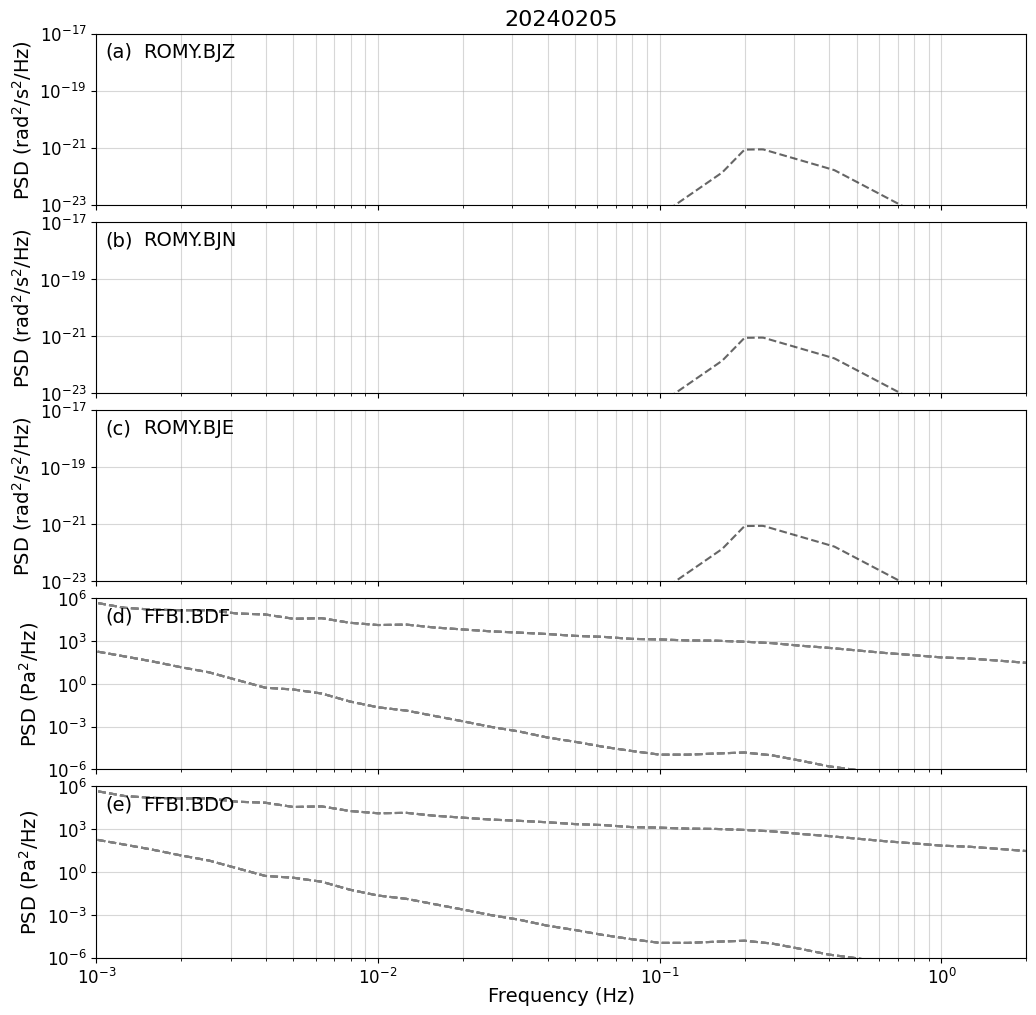

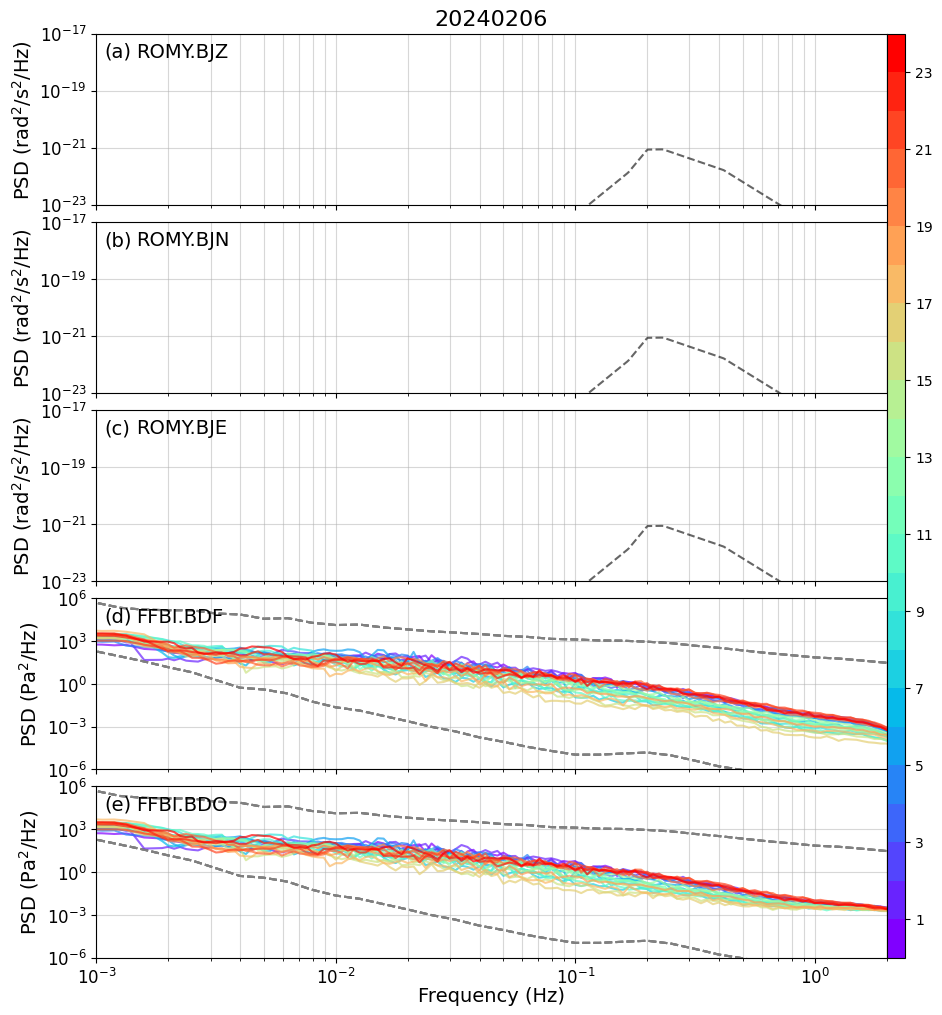

 -> saving: /import/kilauea-data/LNM2/figures/joint_20240206.png

Data1
 -> 4 are all NaN
 -> 11 rows removed due to mean thresholds (0.0019 and 0.0101 Hz)!
 -> 9 / 24 psds remain

Data2
 -> exception !
[Errno 2] No such file or directory: '/import/kilauea-data/LNM2/PSDS/ROMY/2024_ROMY_BJN_3600_20240207_hourly.pkl'

Data1
 -> 0 are all NaN
 -> 0 rows removed due to mean thresholds (0.0019 and 0.0101 Hz)!
 -> 24 / 24 psds remain

Data2
 -> 24 are all NaN
 -> 0 rows removed due to mean thresholds (0.0019 and 0.0101 Hz)!
 -> 0 / 24 psds remain

Data3
 -> 24 are all NaN
 -> 0 rows removed due to mean thresholds (0.0019 and 0.0101 Hz)!
 -> 0 / 24 psds remain

Data4
 -> 0 are all NaN
 -> 0 rows removed due to mean thresholds (0.001 and 1.0001 Hz)!
 -> 24 / 24 psds remain

Data5
 -> 0 are all NaN
 -> 1 rows removed due to mean thresholds (0.001 and 1.0001 Hz)!
 -> 23 / 24 psds remain


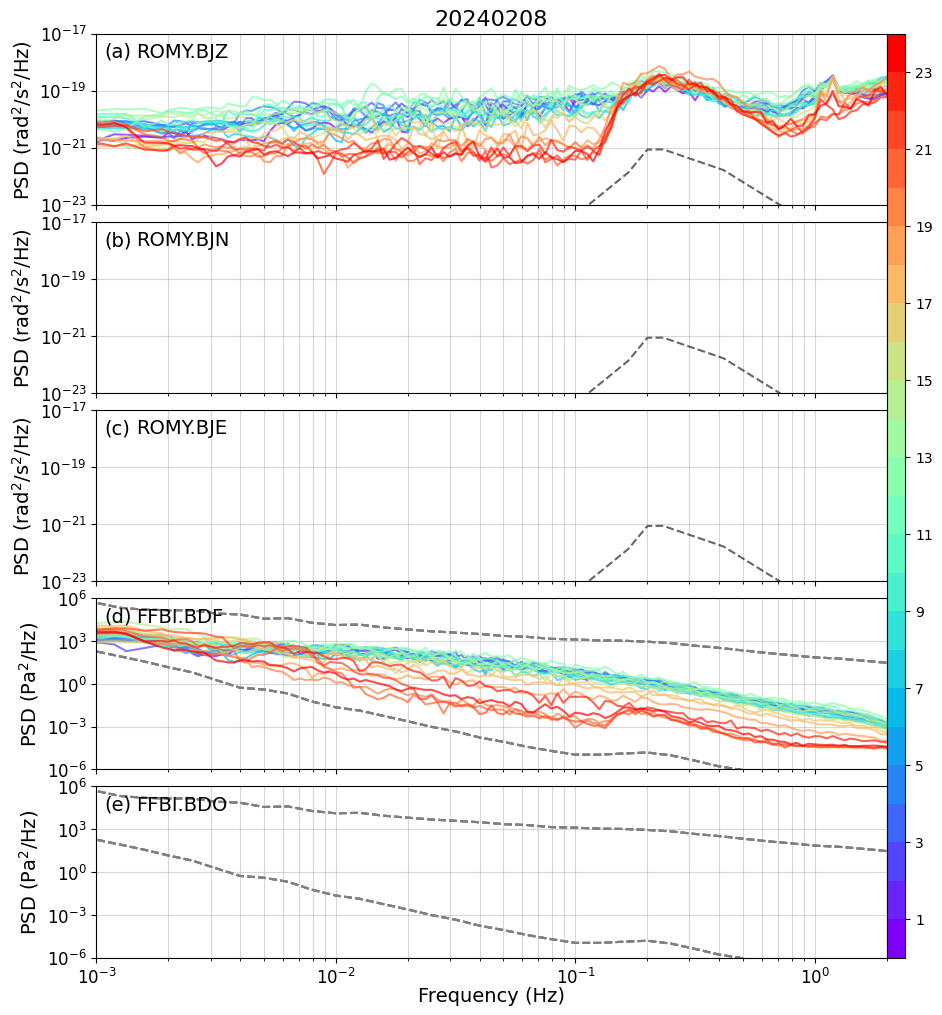

 -> saving: /import/kilauea-data/LNM2/figures/joint_20240208.png

Data1
 -> 0 are all NaN
 -> 0 rows removed due to mean thresholds (0.0019 and 0.0101 Hz)!
 -> 24 / 24 psds remain

Data2
 -> 0 are all NaN
 -> 0 rows removed due to mean thresholds (0.0019 and 0.0101 Hz)!
 -> 24 / 24 psds remain

Data3
 -> 0 are all NaN
 -> 2 rows removed due to mean thresholds (0.0019 and 0.0101 Hz)!
 -> 22 / 24 psds remain

Data4
 -> 0 are all NaN
 -> 0 rows removed due to mean thresholds (0.001 and 1.0001 Hz)!
 -> 24 / 24 psds remain

Data5
 -> 0 are all NaN
 -> 0 rows removed due to mean thresholds (0.001 and 1.0001 Hz)!
 -> 24 / 24 psds remain


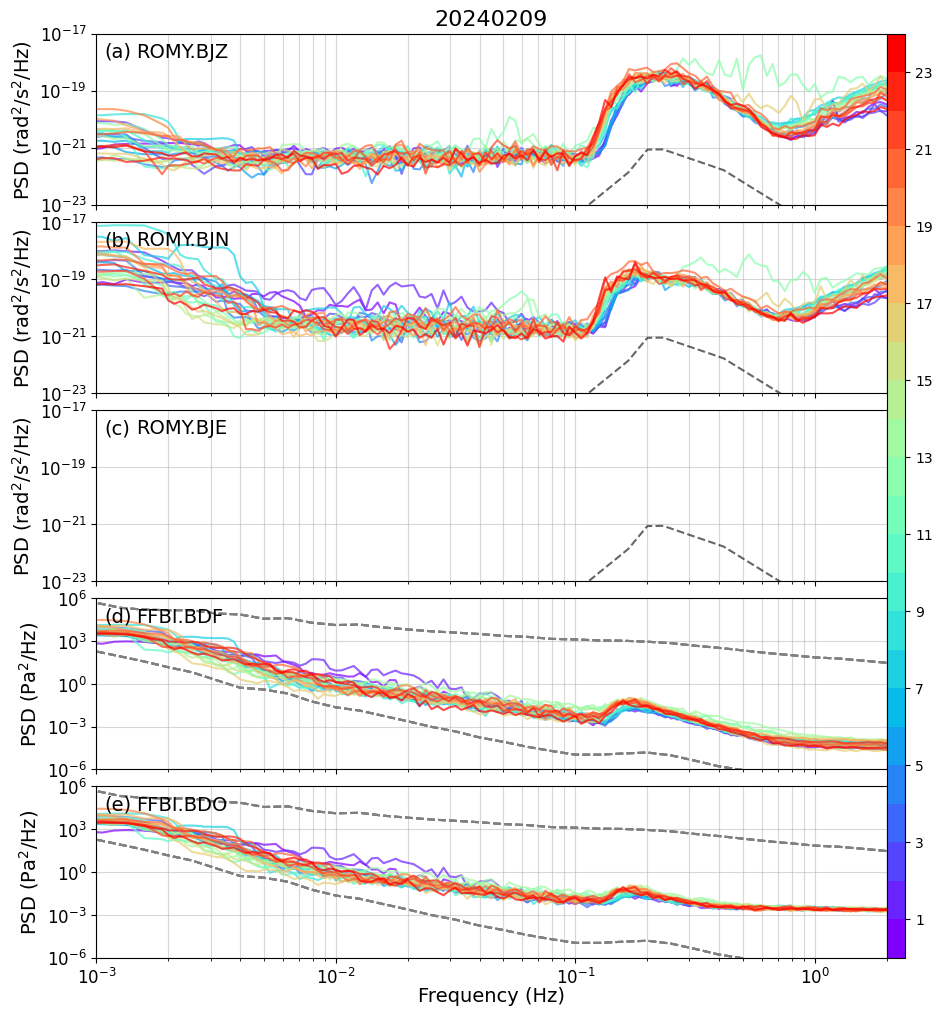

 -> saving: /import/kilauea-data/LNM2/figures/joint_20240209.png

Data1
 -> 0 are all NaN
 -> 0 rows removed due to mean thresholds (0.0019 and 0.0101 Hz)!
 -> 24 / 24 psds remain

Data2
 -> 0 are all NaN
 -> 4 rows removed due to mean thresholds (0.0019 and 0.0101 Hz)!
 -> 20 / 24 psds remain

Data3
 -> 0 are all NaN
 -> 6 rows removed due to mean thresholds (0.0019 and 0.0101 Hz)!
 -> 18 / 24 psds remain

Data4
 -> 0 are all NaN
 -> 0 rows removed due to mean thresholds (0.001 and 1.0001 Hz)!
 -> 24 / 24 psds remain

Data5
 -> 0 are all NaN
 -> 0 rows removed due to mean thresholds (0.001 and 1.0001 Hz)!
 -> 24 / 24 psds remain


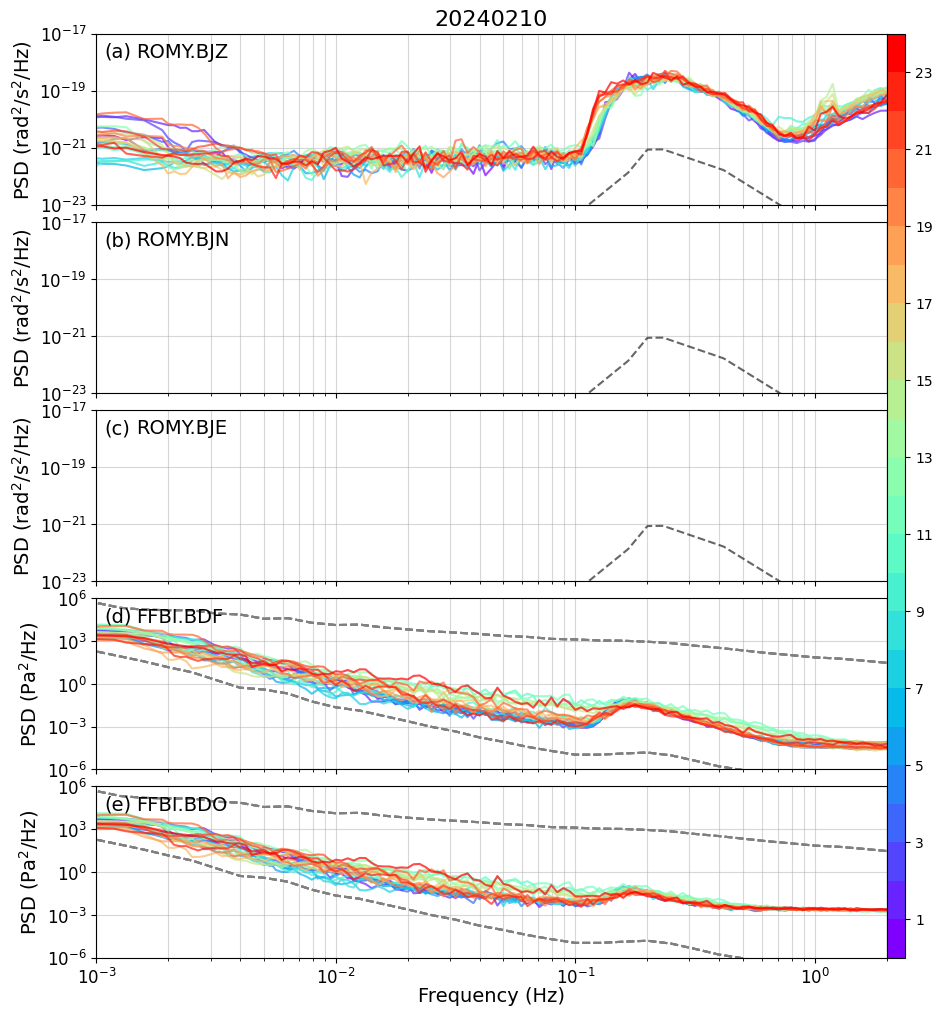

 -> saving: /import/kilauea-data/LNM2/figures/joint_20240210.png

Data1
 -> 0 are all NaN
 -> 1 rows removed due to mean thresholds (0.0019 and 0.0101 Hz)!
 -> 23 / 24 psds remain

Data2
 -> 0 are all NaN
 -> 0 rows removed due to mean thresholds (0.0019 and 0.0101 Hz)!
 -> 24 / 24 psds remain

Data3
 -> 0 are all NaN
 -> 0 rows removed due to mean thresholds (0.0019 and 0.0101 Hz)!
 -> 24 / 24 psds remain

Data4
 -> 0 are all NaN
 -> 0 rows removed due to mean thresholds (0.001 and 1.0001 Hz)!
 -> 24 / 24 psds remain

Data5
 -> 0 are all NaN
 -> 0 rows removed due to mean thresholds (0.001 and 1.0001 Hz)!
 -> 24 / 24 psds remain


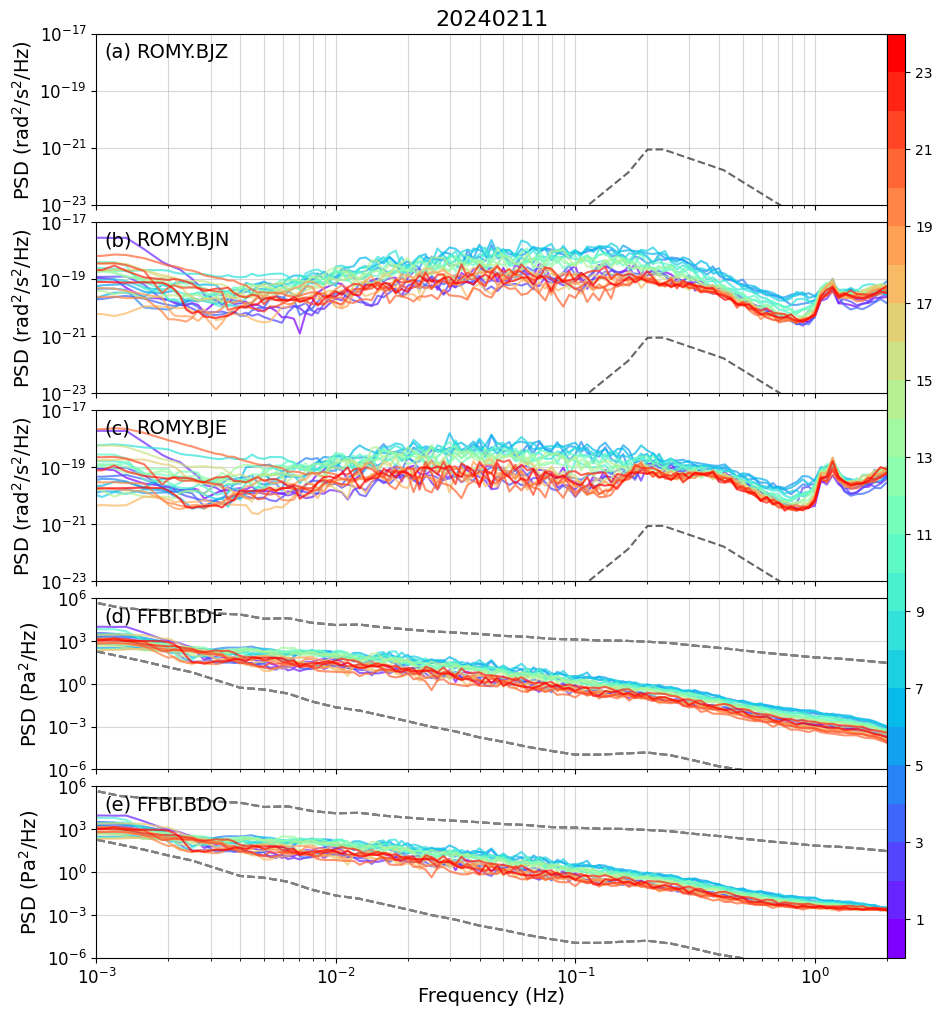

 -> saving: /import/kilauea-data/LNM2/figures/joint_20240211.png

Data1
 -> 0 are all NaN
 -> 3 rows removed due to mean thresholds (0.0019 and 0.0101 Hz)!
 -> 21 / 24 psds remain

Data2
 -> exception !
[Errno 2] No such file or directory: '/import/kilauea-data/LNM2/PSDS/ROMY/2024_ROMY_BJN_3600_20240212_hourly.pkl'

Data1
 -> 2 are all NaN
 -> 0 rows removed due to mean thresholds (0.0019 and 0.0101 Hz)!
 -> 22 / 24 psds remain

Data2
 -> 19 are all NaN
 -> 0 rows removed due to mean thresholds (0.0019 and 0.0101 Hz)!
 -> 5 / 24 psds remain

Data3
 -> 19 are all NaN
 -> 0 rows removed due to mean thresholds (0.0019 and 0.0101 Hz)!
 -> 5 / 24 psds remain

Data4
 -> 0 are all NaN
 -> 0 rows removed due to mean thresholds (0.001 and 1.0001 Hz)!
 -> 24 / 24 psds remain

Data5
 -> 2 are all NaN
 -> 0 rows removed due to mean thresholds (0.001 and 1.0001 Hz)!
 -> 22 / 24 psds remain


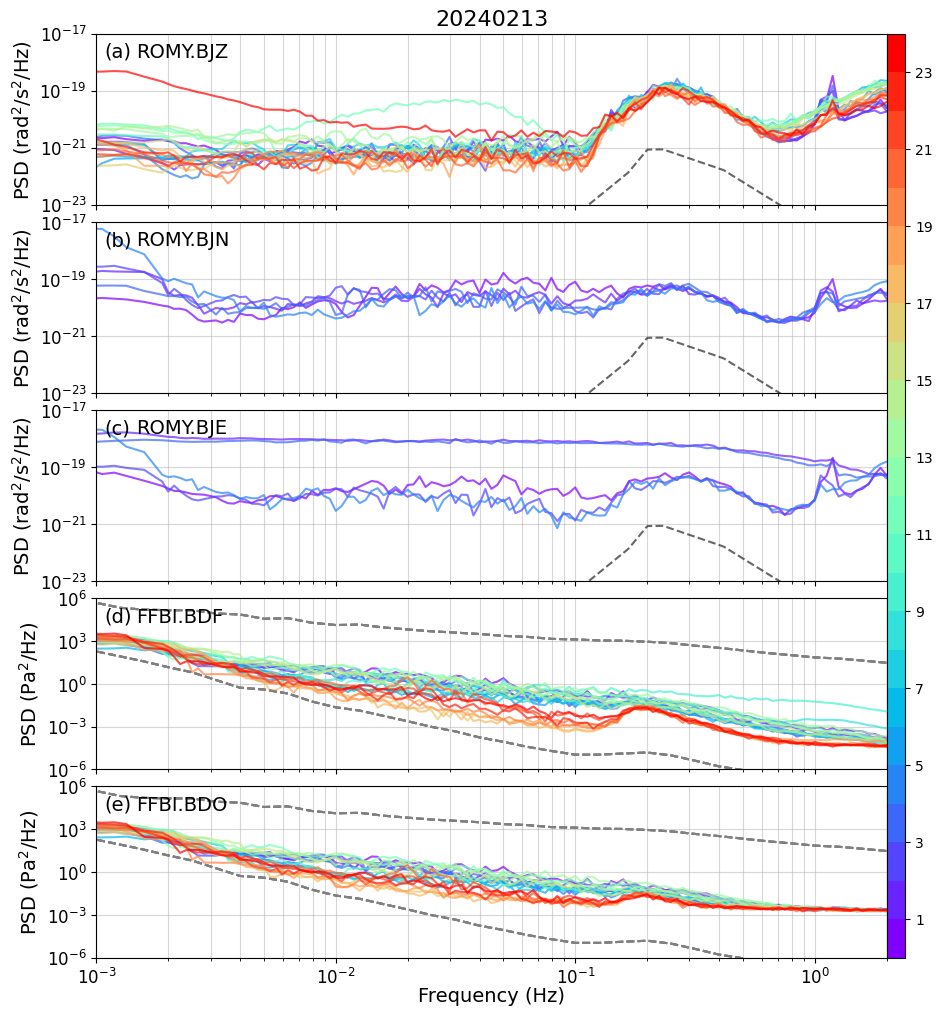

 -> saving: /import/kilauea-data/LNM2/figures/joint_20240213.png

Data1
 -> 0 are all NaN
 -> 0 rows removed due to mean thresholds (0.0019 and 0.0101 Hz)!
 -> 24 / 24 psds remain

Data2
 -> 6 are all NaN
 -> 5 rows removed due to mean thresholds (0.0019 and 0.0101 Hz)!
 -> 13 / 24 psds remain

Data3
 -> 6 are all NaN
 -> 5 rows removed due to mean thresholds (0.0019 and 0.0101 Hz)!
 -> 13 / 24 psds remain

Data4
 -> 0 are all NaN
 -> 0 rows removed due to mean thresholds (0.001 and 1.0001 Hz)!
 -> 24 / 24 psds remain

Data5
 -> 0 are all NaN
 -> 0 rows removed due to mean thresholds (0.001 and 1.0001 Hz)!
 -> 24 / 24 psds remain


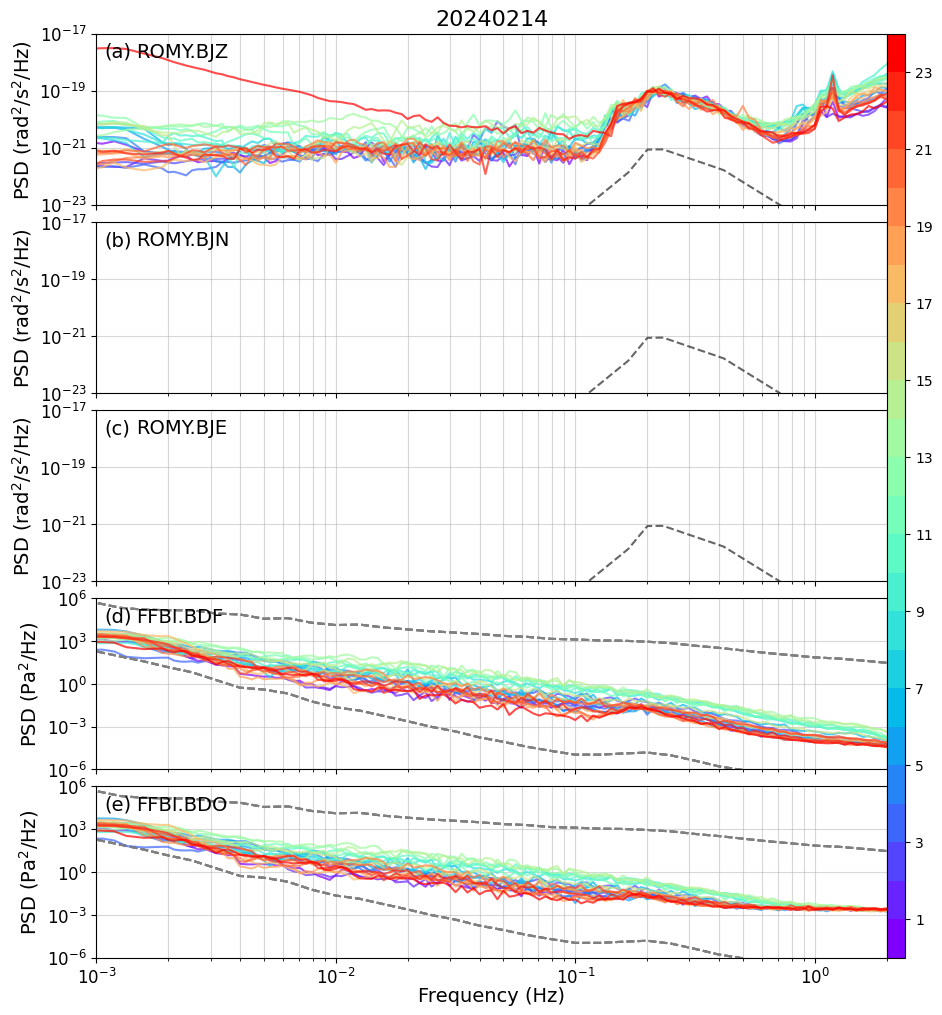

 -> saving: /import/kilauea-data/LNM2/figures/joint_20240214.png

Data1
 -> 7 are all NaN
 -> 0 rows removed due to mean thresholds (0.0019 and 0.0101 Hz)!
 -> 17 / 24 psds remain

Data2
 -> 8 are all NaN
 -> 0 rows removed due to mean thresholds (0.0019 and 0.0101 Hz)!
 -> 16 / 24 psds remain

Data3
 -> 8 are all NaN
 -> 2 rows removed due to mean thresholds (0.0019 and 0.0101 Hz)!
 -> 14 / 24 psds remain

Data4
 -> 0 are all NaN
 -> 0 rows removed due to mean thresholds (0.001 and 1.0001 Hz)!
 -> 24 / 24 psds remain

Data5
 -> 7 are all NaN
 -> 0 rows removed due to mean thresholds (0.001 and 1.0001 Hz)!
 -> 17 / 24 psds remain


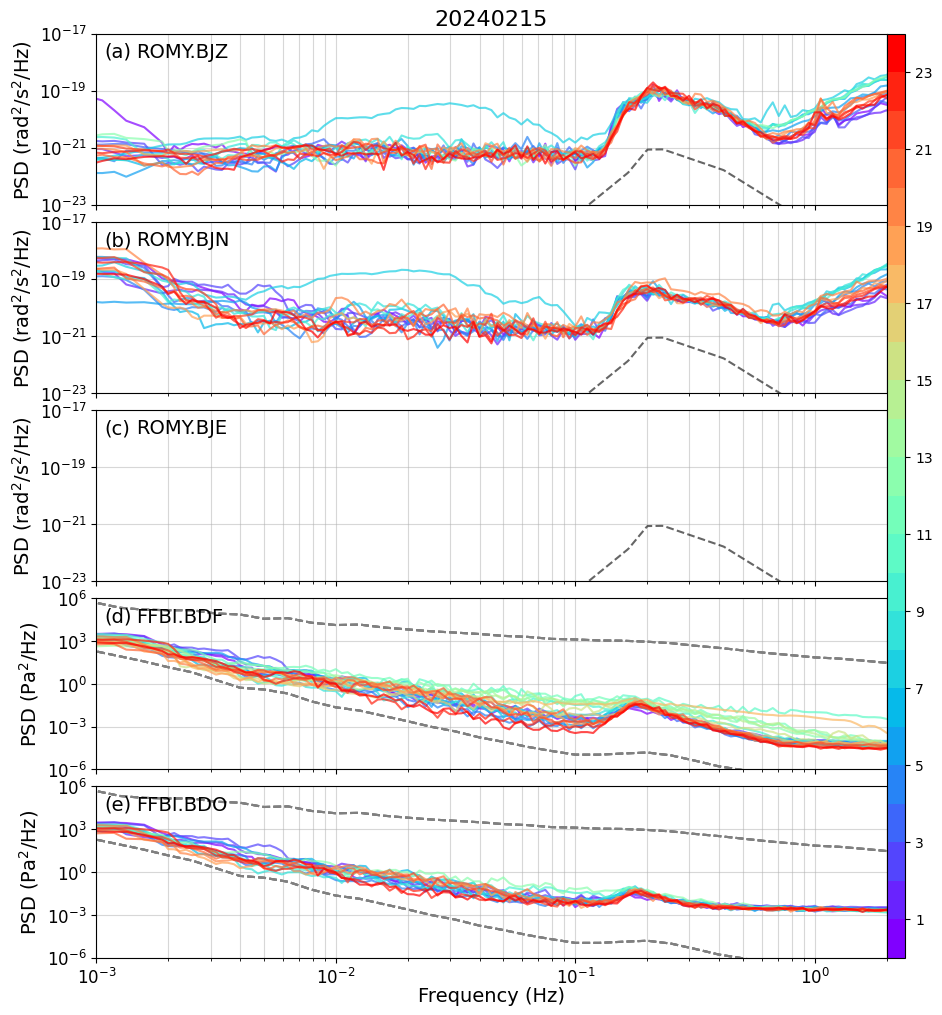

 -> saving: /import/kilauea-data/LNM2/figures/joint_20240215.png

Data1
 -> 1 are all NaN
 -> 2 rows removed due to mean thresholds (0.0019 and 0.0101 Hz)!
 -> 21 / 24 psds remain

Data2
 -> 0 are all NaN
 -> 1 rows removed due to mean thresholds (0.0019 and 0.0101 Hz)!
 -> 23 / 24 psds remain

Data3
 -> 0 are all NaN
 -> 3 rows removed due to mean thresholds (0.0019 and 0.0101 Hz)!
 -> 21 / 24 psds remain

Data4
 -> 0 are all NaN
 -> 0 rows removed due to mean thresholds (0.001 and 1.0001 Hz)!
 -> 24 / 24 psds remain

Data5
 -> 1 are all NaN
 -> 0 rows removed due to mean thresholds (0.001 and 1.0001 Hz)!
 -> 23 / 24 psds remain


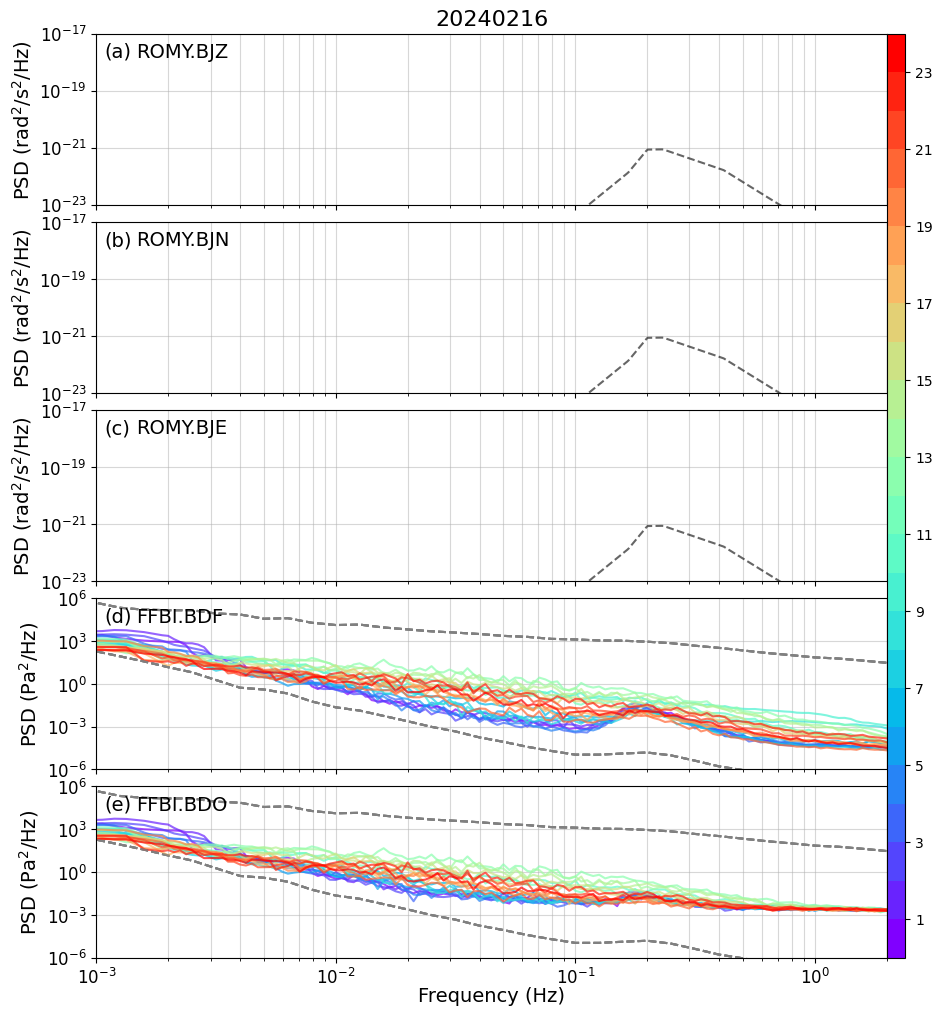

 -> saving: /import/kilauea-data/LNM2/figures/joint_20240216.png

Data1
 -> 0 are all NaN
 -> 1 rows removed due to mean thresholds (0.0019 and 0.0101 Hz)!
 -> 23 / 24 psds remain

Data2
 -> 0 are all NaN
 -> 1 rows removed due to mean thresholds (0.0019 and 0.0101 Hz)!
 -> 23 / 24 psds remain

Data3
 -> 0 are all NaN
 -> 6 rows removed due to mean thresholds (0.0019 and 0.0101 Hz)!
 -> 18 / 24 psds remain

Data4
 -> 0 are all NaN
 -> 0 rows removed due to mean thresholds (0.001 and 1.0001 Hz)!
 -> 24 / 24 psds remain

Data5
 -> 0 are all NaN
 -> 0 rows removed due to mean thresholds (0.001 and 1.0001 Hz)!
 -> 24 / 24 psds remain


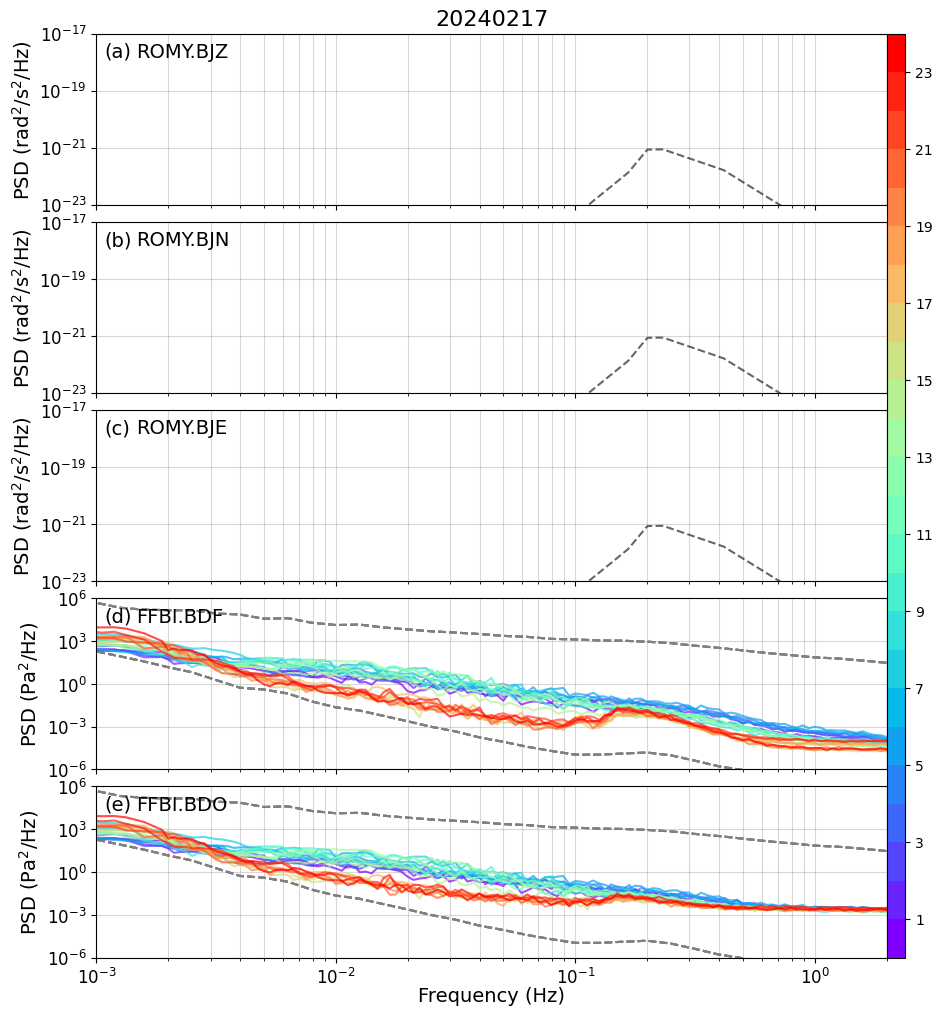

 -> saving: /import/kilauea-data/LNM2/figures/joint_20240217.png

Data1
 -> 0 are all NaN
 -> 0 rows removed due to mean thresholds (0.0019 and 0.0101 Hz)!
 -> 24 / 24 psds remain

Data2
 -> 8 are all NaN
 -> 1 rows removed due to mean thresholds (0.0019 and 0.0101 Hz)!
 -> 15 / 24 psds remain

Data3
 -> 8 are all NaN
 -> 1 rows removed due to mean thresholds (0.0019 and 0.0101 Hz)!
 -> 15 / 24 psds remain

Data4
 -> 0 are all NaN
 -> 0 rows removed due to mean thresholds (0.001 and 1.0001 Hz)!
 -> 24 / 24 psds remain

Data5
 -> 0 are all NaN
 -> 0 rows removed due to mean thresholds (0.001 and 1.0001 Hz)!
 -> 24 / 24 psds remain


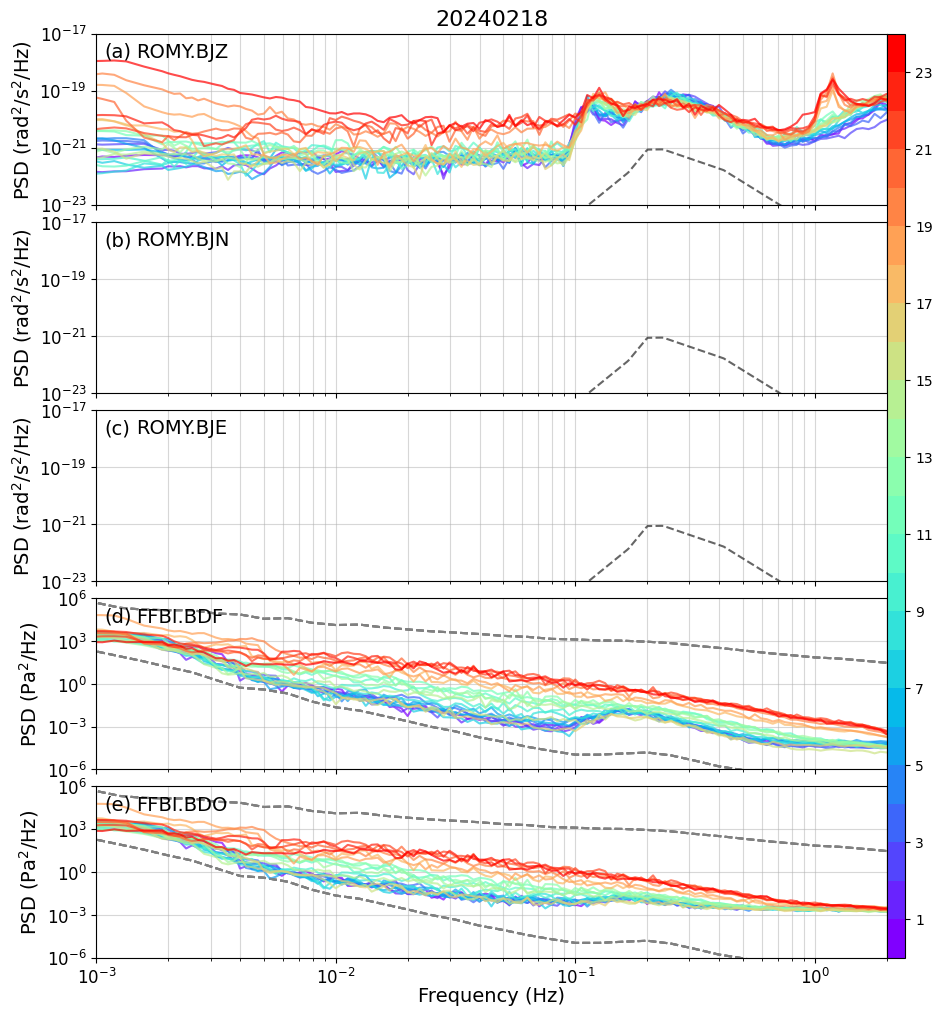

 -> saving: /import/kilauea-data/LNM2/figures/joint_20240218.png

Data1
 -> 0 are all NaN
 -> 2 rows removed due to mean thresholds (0.0019 and 0.0101 Hz)!
 -> 22 / 24 psds remain

Data2
 -> 0 are all NaN
 -> 2 rows removed due to mean thresholds (0.0019 and 0.0101 Hz)!
 -> 22 / 24 psds remain

Data3
 -> 0 are all NaN
 -> 2 rows removed due to mean thresholds (0.0019 and 0.0101 Hz)!
 -> 22 / 24 psds remain

Data4
 -> 0 are all NaN
 -> 0 rows removed due to mean thresholds (0.001 and 1.0001 Hz)!
 -> 24 / 24 psds remain

Data5
 -> 0 are all NaN
 -> 0 rows removed due to mean thresholds (0.001 and 1.0001 Hz)!
 -> 24 / 24 psds remain


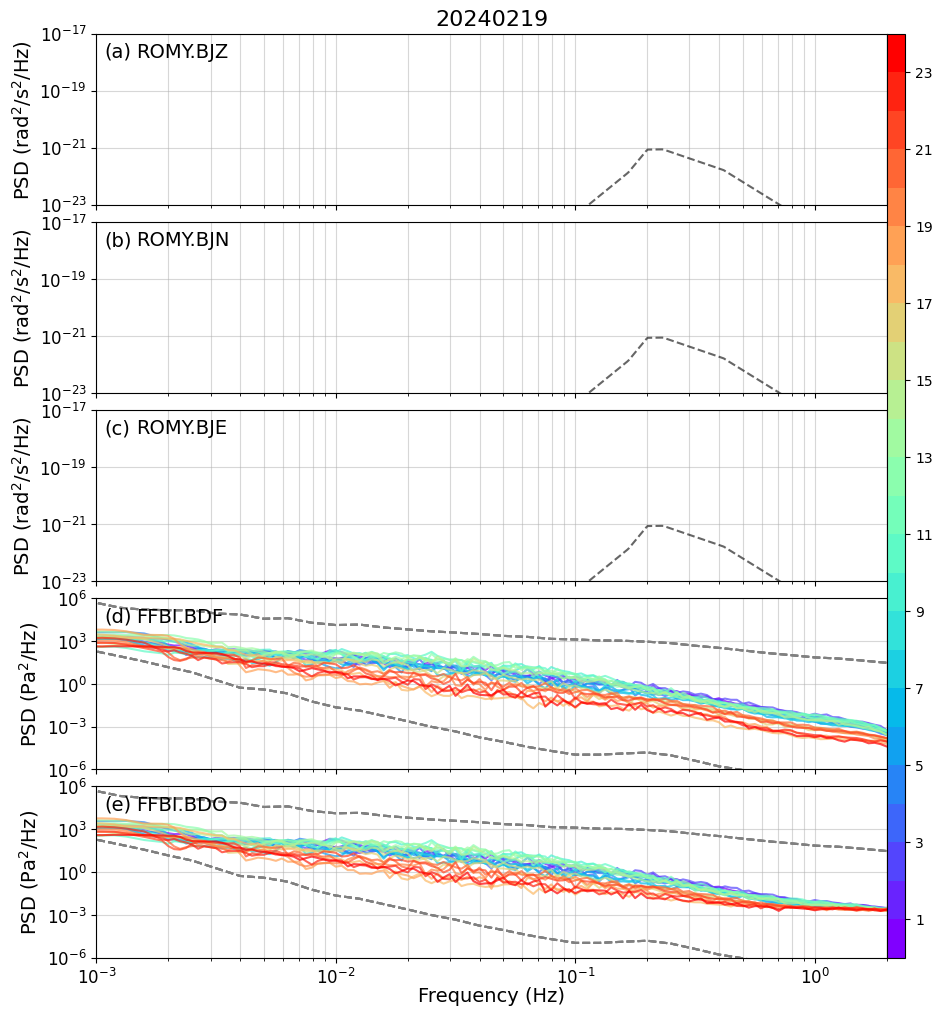

 -> saving: /import/kilauea-data/LNM2/figures/joint_20240219.png

Data1
 -> 0 are all NaN
 -> 2 rows removed due to mean thresholds (0.0019 and 0.0101 Hz)!
 -> 22 / 24 psds remain

Data2
 -> 0 are all NaN
 -> 2 rows removed due to mean thresholds (0.0019 and 0.0101 Hz)!
 -> 22 / 24 psds remain

Data3
 -> 0 are all NaN
 -> 2 rows removed due to mean thresholds (0.0019 and 0.0101 Hz)!
 -> 22 / 24 psds remain

Data4
 -> 0 are all NaN
 -> 0 rows removed due to mean thresholds (0.001 and 1.0001 Hz)!
 -> 24 / 24 psds remain

Data5
 -> 0 are all NaN
 -> 0 rows removed due to mean thresholds (0.001 and 1.0001 Hz)!
 -> 24 / 24 psds remain


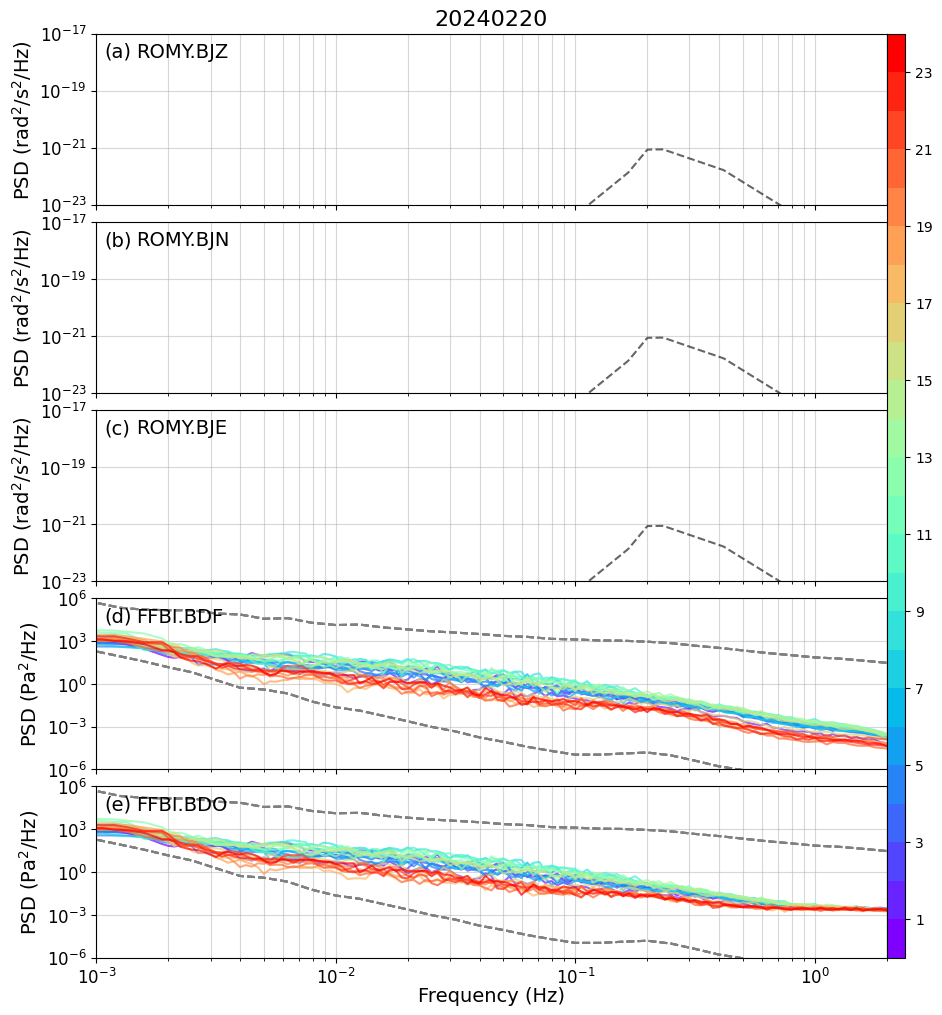

 -> saving: /import/kilauea-data/LNM2/figures/joint_20240220.png

Data1
 -> 0 are all NaN
 -> 1 rows removed due to mean thresholds (0.0019 and 0.0101 Hz)!
 -> 23 / 24 psds remain

Data2
 -> 1 are all NaN
 -> 8 rows removed due to mean thresholds (0.0019 and 0.0101 Hz)!
 -> 15 / 24 psds remain

Data3
 -> 1 are all NaN
 -> 7 rows removed due to mean thresholds (0.0019 and 0.0101 Hz)!
 -> 16 / 24 psds remain

Data4
 -> 0 are all NaN
 -> 0 rows removed due to mean thresholds (0.001 and 1.0001 Hz)!
 -> 24 / 24 psds remain

Data5
 -> 0 are all NaN
 -> 0 rows removed due to mean thresholds (0.001 and 1.0001 Hz)!
 -> 24 / 24 psds remain


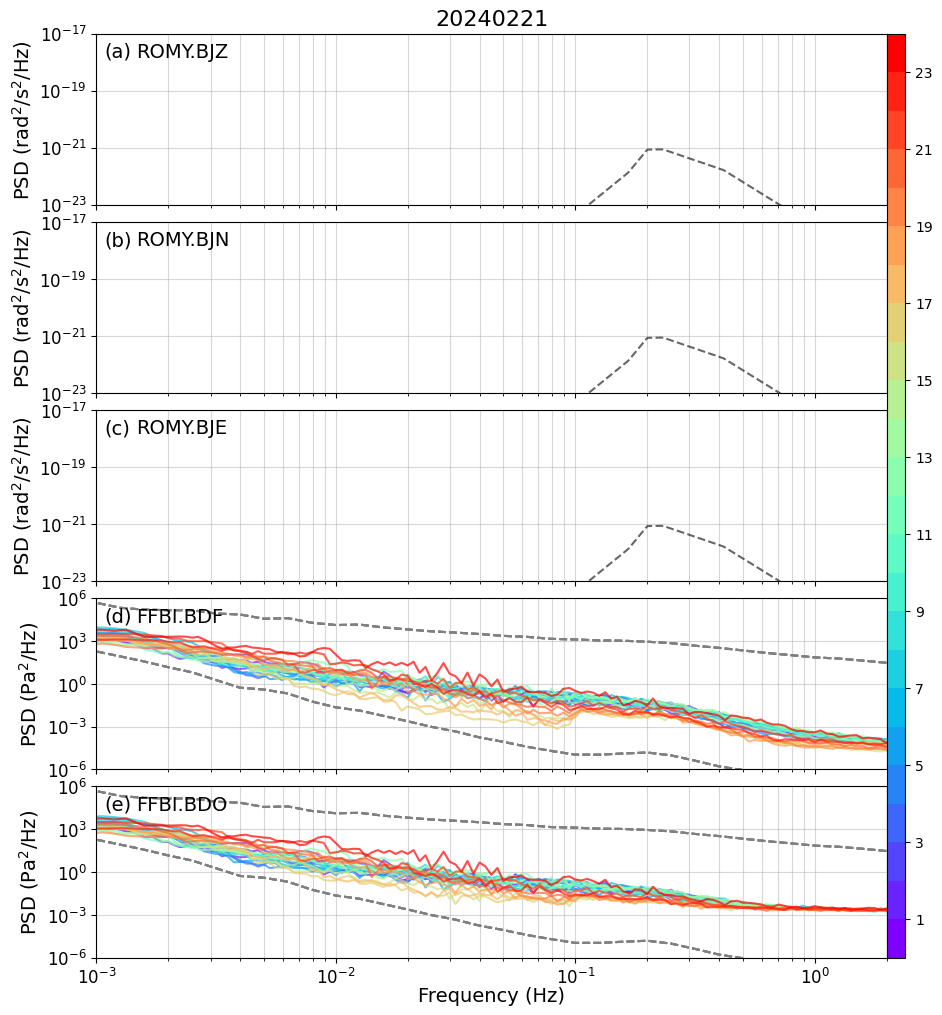

 -> saving: /import/kilauea-data/LNM2/figures/joint_20240221.png

Data1
 -> 0 are all NaN
 -> 1 rows removed due to mean thresholds (0.0019 and 0.0101 Hz)!
 -> 23 / 24 psds remain

Data2
 -> 1 are all NaN
 -> 2 rows removed due to mean thresholds (0.0019 and 0.0101 Hz)!
 -> 21 / 24 psds remain

Data3
 -> 1 are all NaN
 -> 2 rows removed due to mean thresholds (0.0019 and 0.0101 Hz)!
 -> 21 / 24 psds remain

Data4
 -> 0 are all NaN
 -> 0 rows removed due to mean thresholds (0.001 and 1.0001 Hz)!
 -> 24 / 24 psds remain

Data5
 -> 0 are all NaN
 -> 0 rows removed due to mean thresholds (0.001 and 1.0001 Hz)!
 -> 24 / 24 psds remain


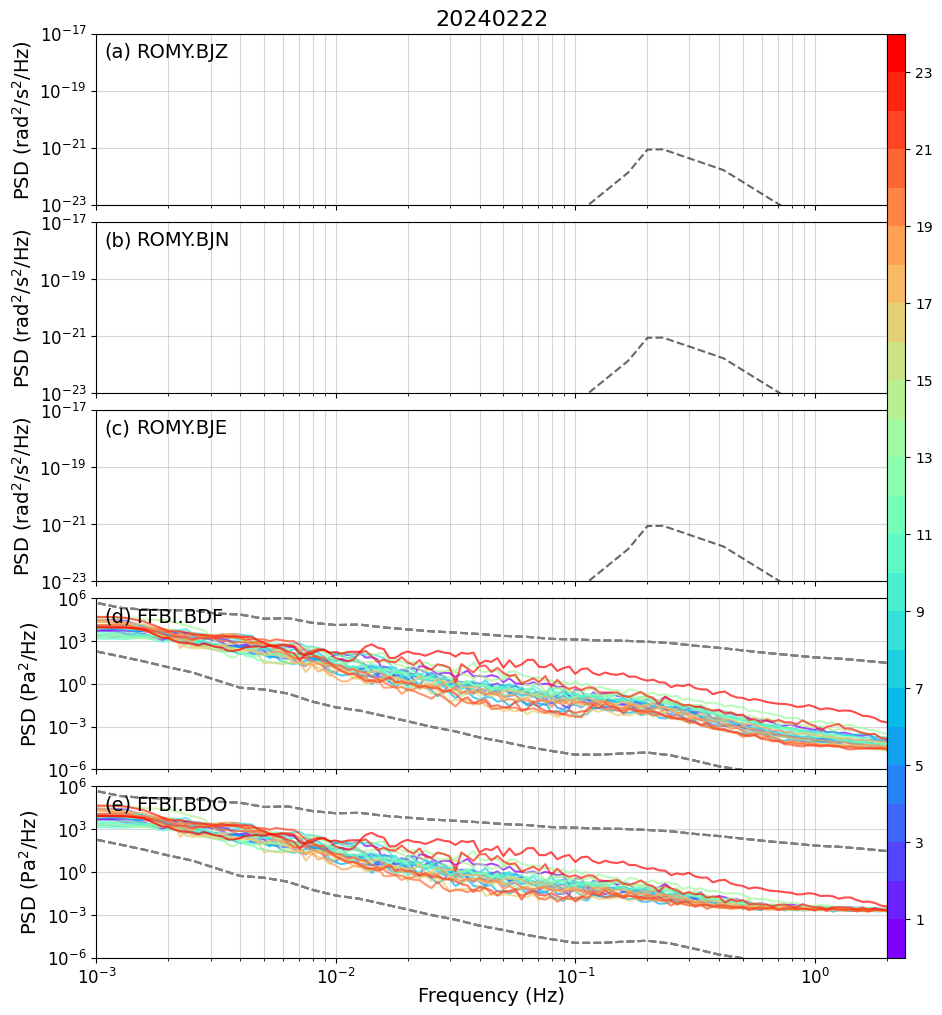

 -> saving: /import/kilauea-data/LNM2/figures/joint_20240222.png

Data1
 -> 1 are all NaN
 -> 2 rows removed due to mean thresholds (0.0019 and 0.0101 Hz)!
 -> 21 / 24 psds remain

Data2
 -> 6 are all NaN
 -> 3 rows removed due to mean thresholds (0.0019 and 0.0101 Hz)!
 -> 15 / 24 psds remain

Data3
 -> 6 are all NaN
 -> 3 rows removed due to mean thresholds (0.0019 and 0.0101 Hz)!
 -> 15 / 24 psds remain

Data4
 -> 0 are all NaN
 -> 0 rows removed due to mean thresholds (0.001 and 1.0001 Hz)!
 -> 24 / 24 psds remain

Data5
 -> 0 are all NaN
 -> 0 rows removed due to mean thresholds (0.001 and 1.0001 Hz)!
 -> 24 / 24 psds remain


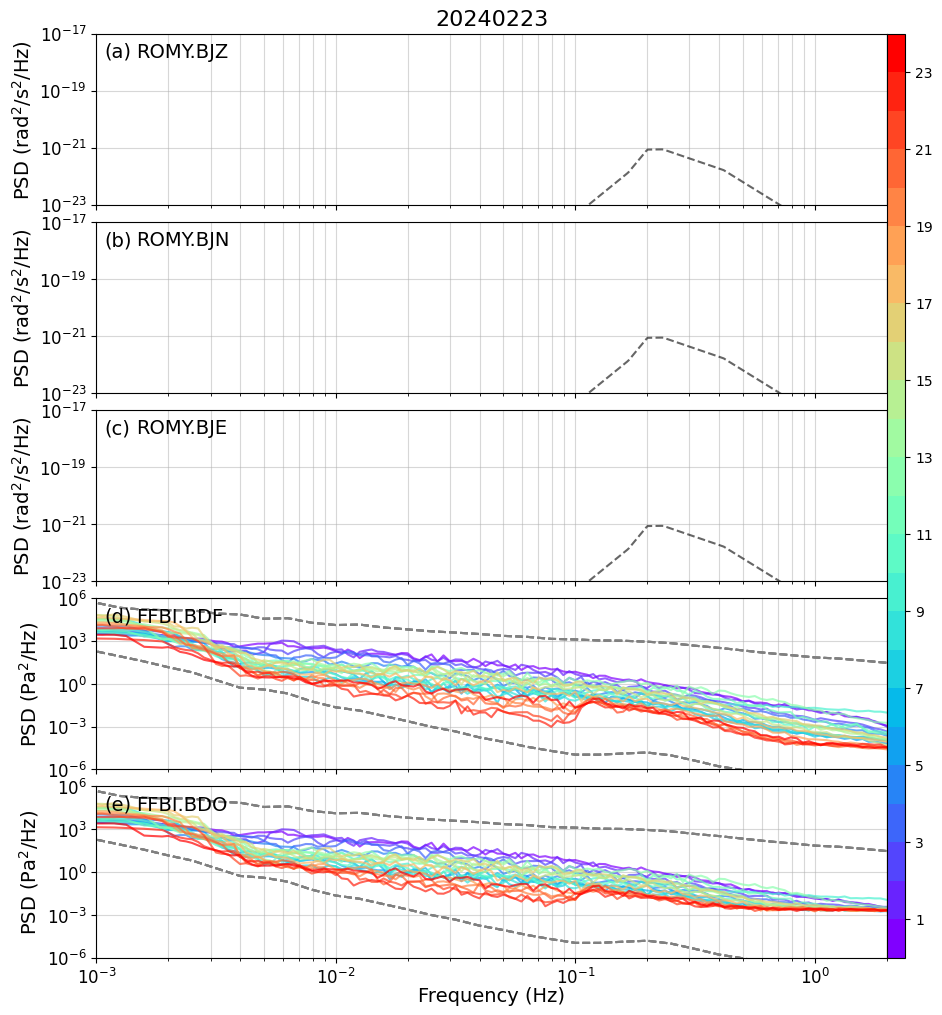

 -> saving: /import/kilauea-data/LNM2/figures/joint_20240223.png

Data1
 -> 1 are all NaN
 -> 1 rows removed due to mean thresholds (0.0019 and 0.0101 Hz)!
 -> 22 / 24 psds remain

Data2
 -> 4 are all NaN
 -> 9 rows removed due to mean thresholds (0.0019 and 0.0101 Hz)!
 -> 11 / 24 psds remain

Data3
 -> 4 are all NaN
 -> 10 rows removed due to mean thresholds (0.0019 and 0.0101 Hz)!
 -> 10 / 24 psds remain

Data4
 -> 0 are all NaN
 -> 0 rows removed due to mean thresholds (0.001 and 1.0001 Hz)!
 -> 24 / 24 psds remain

Data5
 -> 0 are all NaN
 -> 0 rows removed due to mean thresholds (0.001 and 1.0001 Hz)!
 -> 24 / 24 psds remain


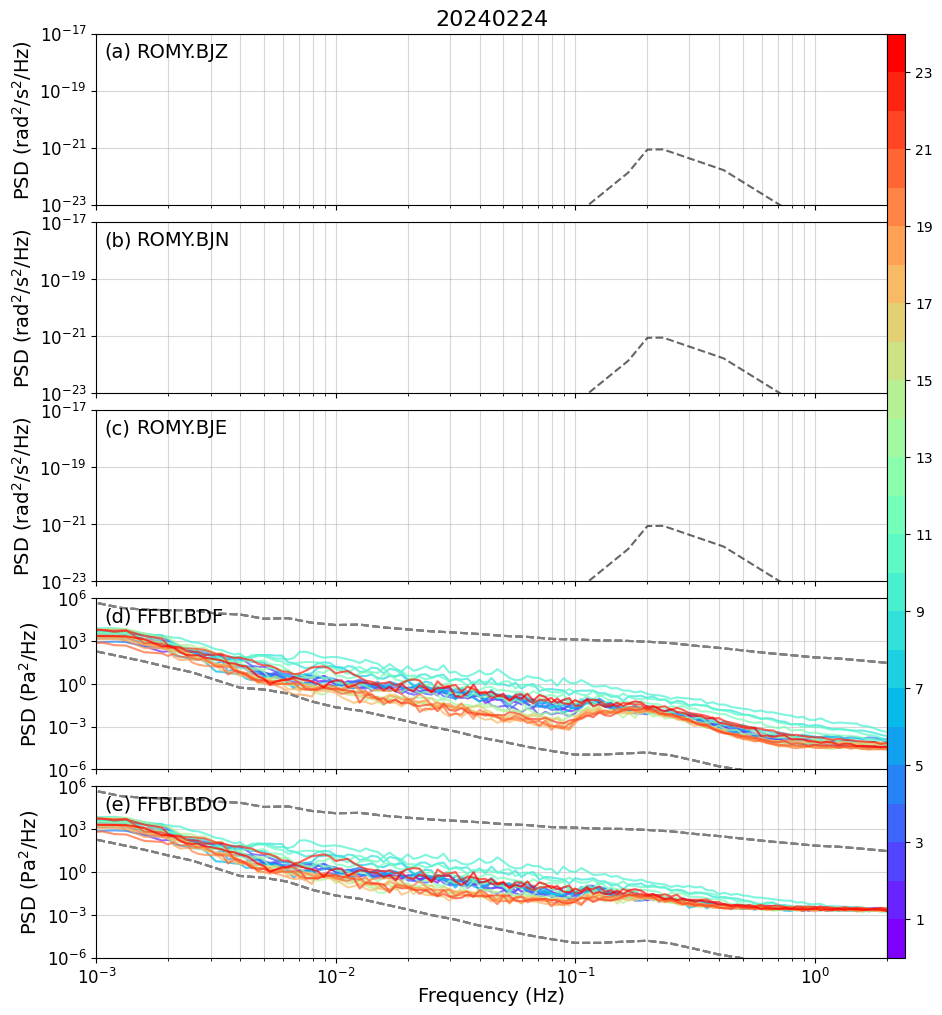

 -> saving: /import/kilauea-data/LNM2/figures/joint_20240224.png

Data1
 -> 0 are all NaN
 -> 1 rows removed due to mean thresholds (0.0019 and 0.0101 Hz)!
 -> 23 / 24 psds remain

Data2
 -> 0 are all NaN
 -> 1 rows removed due to mean thresholds (0.0019 and 0.0101 Hz)!
 -> 23 / 24 psds remain

Data3
 -> 0 are all NaN
 -> 2 rows removed due to mean thresholds (0.0019 and 0.0101 Hz)!
 -> 22 / 24 psds remain

Data4
 -> 0 are all NaN
 -> 0 rows removed due to mean thresholds (0.001 and 1.0001 Hz)!
 -> 24 / 24 psds remain

Data5
 -> 0 are all NaN
 -> 0 rows removed due to mean thresholds (0.001 and 1.0001 Hz)!
 -> 24 / 24 psds remain


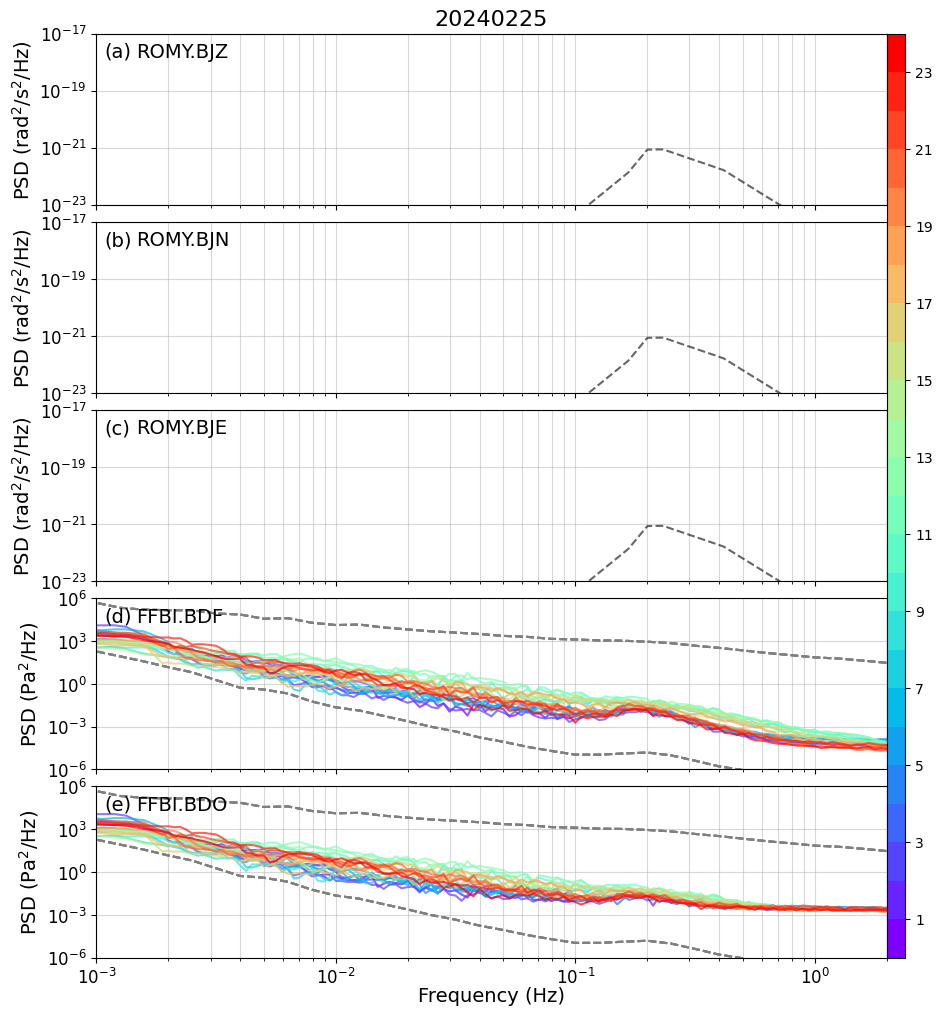

 -> saving: /import/kilauea-data/LNM2/figures/joint_20240225.png


In [10]:

psds_medians_out, times_out = [], []

rejected_dat1, rejected_dat2, rejected_dat3, rejected_dat4, rejected_dat5 = [], [], [], [], []

for _i, day in enumerate(date_range(config['d1'], config['d2'])):

    day = str(day).split(" ")[0].replace("-", "")

    config['outpath_figname'] = "joint_"+day

    # if _i > 3:
    #     continue

    # if os.path.isfile(config['outpath_figures']+config['outpath_figname']):
    #     print(f" -> skipping {config['outpath_figname']} ...")
    #     continue


    try:


        ## Data1 --------------------------
        print("\nData1")
        name1 = f"ROMY/{config['year']}_ROMY_BJZ"

        out = read_pickle(config['path_to_data']+f"{name1}_3600_{day}_hourly.pkl")
        ff1, dat1 = out['frequencies'], out['psd']

        dat1, rejected_dat1 = __replace_noisy_psds_with_nan(dat1, ff=ff1, threshold_mean=5e-19, threshold_min=1e-23, flim=[0.002, 0.01])
        # dat1, ff1 = __cut_frequencies_array(dat1, ff1, config['frequency_limits'][0], config['frequency_limits'][1])
        ff1, dat1 = __get_fband_averages(ff1, dat1)

        if len(rejected_dat1) > 0:
            ff1, rejected_dat1 = __get_fband_averages(ff1, rejected_dat1)

        ## Data2 --------------------------
        print("\nData2")
        name2 = f"ROMY/{config['year']}_ROMY_BJN"

        out = read_pickle(config['path_to_data']+f"{name2}_3600_{day}_hourly.pkl")
        ff2, dat2 = out['frequencies'], out['psd']

        dat2, rejected_dat2 = __replace_noisy_psds_with_nan(dat2, ff=ff2, threshold_mean=1e-17, threshold_min=1e-22, flim=[0.002, 0.01])
        # dat2, ff2 = __cut_frequencies_array(dat2, ff2, config['frequency_limits'][0], config['frequency_limits'][1])
        ff2, dat2 = __get_fband_averages(ff2, dat2)

        if len(rejected_dat2) > 0:
            ff2, rejected_dat2 = __get_fband_averages(ff2, rejected_dat2)


        ## Data3 --------------------------
        print("\nData3")
        name3 = f"ROMY/{config['year']}_ROMY_BJE"

        out = read_pickle(config['path_to_data']+f"{name3}_3600_{day}_hourly.pkl")
        ff3, dat3 = out['frequencies'], out['psd']

        dat3, rejected_dat3 = __replace_noisy_psds_with_nan(dat3, ff=ff3, threshold_mean=1e-17, threshold_min=1e-22, flim=[0.002, 0.01])
        # dat3, ff3 = __cut_frequencies_array(dat3, ff3, config['frequency_limits'][0], config['frequency_limits'][1])
        ff3, dat3 = __get_fband_averages(ff3, dat3)

        if len(rejected_dat3) > 0:
            ff3, rejected_dat3 = __get_fband_averages(ff3, rejected_dat3)


        ## Data4 --------------------------
        print("\nData4")
        name4 = f"FFBI/{config['year']}_FFBI_BDF"

        out = read_pickle(config['path_to_data']+f"{name4}_3600_{day}_hourly.pkl")
        ff4, dat4 = out['frequencies'], out['psd']

        dat4, rejected_dat4 = __replace_noisy_psds_with_nan(dat4, ff=ff4, threshold_mean=1e7, threshold_min=1e-7, flim=[0.001, 1.0])
        # dat4, ff4 = __cut_frequencies_array(dat4, ff4, config['frequency_limits'][0], config['frequency_limits'][1])
        ff4, dat4 = __get_fband_averages(ff4, dat4)

        if len(rejected_dat4) > 0:
            ff4, rejected_dat4 = __get_fband_averages(ff4, rejected_dat4)


        ## Data5 --------------------------
        print("\nData5")
        name5 = f"FFBI/{config['year']}_FFBI_BDO"

        out = read_pickle(config['path_to_data']+f"{name5}_3600_{day}_hourly.pkl")
        ff5, dat5 = out['frequencies'], out['psd']

        dat5, rejected_dat5 = __replace_noisy_psds_with_nan(dat5, ff=ff5, threshold_mean=1e7, threshold_min=1e-5, flim=[0.001, 1.0])
        # dat5, ff5 = __cut_frequencies_array(dat5, ff5, config['frequency_limits'][0], config['frequency_limits'][1])
        ff5, dat5 = __get_fband_averages(ff5, dat5)

        if len(rejected_dat5) > 0:
            ff5, rejected_dat5 = __get_fband_averages(ff5, rejected_dat5)


    except Exception as e:
        print(" -> exception !")
        print(e)
        continue

    try:
        fig = __makeplot_colorlines_overview(config,
                                             [ff1, ff2, ff3, ff4, ff5],
                                             [dat1, dat2, dat3, dat4, dat5],
                                             [rejected_dat1, rejected_dat2, rejected_dat3, rejected_dat4, rejected_dat5],
                                             [name1, name2, name3, name4, name5],
                                             day,
                                             show_rejected=True)
    except:
        pass

    ## define file appendix
    app = f"_{name1[-1]}{name2[-1]}{name3[-1]}"

    print(f" -> saving: {config['outpath_figures']}{config['outpath_figname']}.png")
    fig.savefig(config['outpath_figures']+"joint_ROMY/"+config['outpath_figname']+f"_ROMY{app}.png", format="png", transparent=False, bbox_inches='tight', dpi=150)


In [ ]:
# os.system("""spd-say "Finished" """)